In [142]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import statistics
import pyspark
from pyspark import SparkContext
from pyspark.mllib.fpm import FPGrowth
import re
%matplotlib inline  

from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import CountVectorizer
from pyspark.mllib.linalg import *
from pyspark.mllib.linalg.distributed import RowMatrix
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

In [2]:
def read_file(file):
    all_papers = []
    one_paper = {'title': '',  'venue': '', 'index': ''}
    with open(file, 'r',encoding='utf-8') as content_file:
        line_counter = 0
        most_recent_mark = ''
        for one_line in content_file:
            line_counter = line_counter + 1
            one_line = one_line.rstrip('\n')
            if len(one_line) != 0 and one_line[0] == '#':
                most_recent_mark = one_line[:2]
            if len(one_line) == 0:
                flag = True
                for attr in one_paper:  # check if extra empty row exists
                    flag = flag and (len(one_paper[attr]) == 0)
                if flag:
                    print ('empty row' + str(line_counter))
                else:
                    all_papers.append(one_paper)
                    one_paper = {'title': '', 'venue': '', 'index': ''}
            elif one_line[:2] == '#*':
                one_paper['title'] = one_line[2:]
            elif one_line[:2] == '#c':
                one_paper['venue'] = one_line[2:]
            elif one_line[:2] == '#i':
                one_paper['index'] = one_line[6:]
            else:
                nomatch=1
        print ('line_counter: ' + str(line_counter))
        return all_papers


In [3]:
# read publications file
all_data_list = read_file("publications.txt")

line_counter: 2149329


In [4]:
# store title data to a data frame
l=[]
for x in all_data_list:
    if (len(x["title"]) != 0 ):
        l.append(x["title"].split(" "))

df = pd.DataFrame({'title':l})



In [6]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('local')
spark = SparkSession(sc)

In [7]:
#transform txt to spark_df
spark_df = spark.createDataFrame(df)

In [8]:
#2.a
# first count words to extract features as a vector
# Input data: Each row is a bag of words with a ID.
from pyspark.ml.feature import CountVectorizer
df = spark_df
# fit a CountVectorizerModel from the corpus.
cv = CountVectorizer(inputCol="title", outputCol="features", vocabSize=1000, minDF=0)
model = cv.fit(df)
result = model.transform(df)

In [58]:
# run PCA, reduce to 50 dims

#df = result
pca = PCA(k=50, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(result)

pca_result = model.transform(result).select("pcaFeatures")
pca_result.show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [59]:
# see variance explained
sum(model.explainedVariance)

0.49638351898847816

In [63]:
#2.b

# to get 50% variance, adjust k , we see k=52 is enough
pca = PCA(k=52, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(result)
pca_result = model.transform(result).select("pcaFeatures")
print("variance explained" + str(sum(model.explainedVariance)))

variance explained0.5008143971006735


In [72]:
# extract eigenvalue, since currently pyspark doest support extract eigenvalue directly from pca model
# im using the svd decomposition extract singular values
from pyspark.mllib.linalg.distributed import RowMatrix
mat = mat = RowMatrix(pca_result.rdd.map(lambda v: Vectors.dense(v.pcaFeatures.toArray()) ))
svd = mat.computeSVD(50)
s = svd.s   

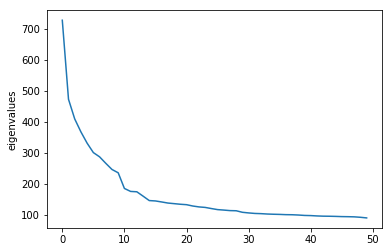

In [78]:
l = DenseVector(s)
plt.plot(l)
plt.ylabel('eigenvalues')
plt.show()

In [81]:
#2.c


In [11]:
#2.d
pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(result)
pca_result = model.transform(result).select("pcaFeatures")


In [22]:
l=pca_result.select("pcaFeatures").collect()

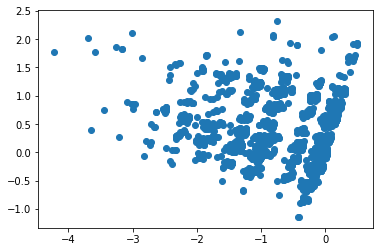

In [60]:
xx=[]
yy=[]
for x in l[:10000]:
    xx.append(x[0][0])
    yy.append(x[0][1])
plt.scatter(xx,yy)
plt.show()

In [ ]:
# we didn;t see much of structure, this could because 2 component based on our feature vector doesnt catch enough variance in data;
# could be 2 dimension is too less; or our vectorization step didnt extract good feature; (n-gram, remove stop word might be useful)

In [7]:
#2.e
#remove stop word:
# read stop words file
with open("stopwords_english.txt", "r") as stop_file:
    stop=[]
    for x in stop_file:
         stop.append(x.rstrip('\n'))
### remove them
l=[]
for x in all_data_list:
    if (len(x["title"]) != 0 ):
        l.append(x["title"].split(" "))
df = pd.DataFrame({'title':l})
df = pd.DataFrame(df['title'].apply(lambda x: [item for item in x if item not in stop]))
     

In [8]:
spark_df = spark.createDataFrame(df)

In [9]:
#re run pca
df = spark_df
# fit a CountVectorizerModel from the corpus.
cv = CountVectorizer(inputCol="title", outputCol="features", vocabSize=1000, minDF=0)
model = cv.fit(df)
result = model.transform(df)
pca = PCA(k=50, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(result)

pca_result = model.transform(result).select("pcaFeatures")
pca_result.show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

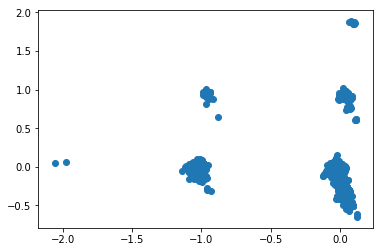

In [11]:
pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(result)
pca_result = model.transform(result).select("pcaFeatures")
l=pca_result.select("pcaFeatures").collect()
xx=[]
yy=[]
for x in l[:10000]:
    xx.append(x[0][0])
    yy.append(x[0][1])
plt.scatter(xx,yy)
plt.show()

#### after removing stop words we see there is a clustered structure, i think the stop words here are somehow like noise; they appear a lot but dont really offer any useful information regarding the  publication

In [ ]:
#2.f : tf-idf; this could account the base frequency of words when measuring the frequency of words in our corps;

In [94]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer


l=[]
for x in all_data_list:
    if (len(x["title"]) != 0 ):
        l.append(x["title"].split(" "))
df = pd.DataFrame({'title':l})
df = pd.DataFrame(df['title'].apply(lambda x: [item for item in x if item not in stop]))
df["title"] = (df["title"].apply(lambda x: ",".join(x) if isinstance(x, list) else x))
sentenceData = spark.createDataFrame(df) 
tokenizer = Tokenizer(inputCol="title", outputCol="words")
wordsData = tokenizer.transform(sentenceData)

hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=1000)
featurizedData = hashingTF.transform(wordsData)
# alternatively, CountVectorizer can also be used to get term frequency vectors

idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)

rescaledData.show(5)

+--------------------+--------------------+------------------+--------------------+
|               title|               words|       rawFeatures|            features|
+--------------------+--------------------+------------------+--------------------+
|Overview,ADDS,Sys...|[overview,adds,sy...|(1000,[927],[1.0])|(1000,[927],[6.94...|
|Where,Object-Orie...|[where,object-ori...|(1000,[287],[1.0])|(1000,[287],[6.89...|
|Cooperative,Trans...|[cooperative,tran...|(1000,[761],[1.0])|(1000,[761],[6.93...|
|Schema,Architectu...|[schema,architect...|(1000,[346],[1.0])|(1000,[346],[6.93...|
|On,View,Support,O...|[on,view,support,...|(1000,[770],[1.0])|(1000,[770],[6.89...|
+--------------------+--------------------+------------------+--------------------+
only showing top 5 rows



In [95]:
pca = PCA(k=50, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(rescaledData)

pca_result = model.transform(rescaledData).select("pcaFeatures")
pca_result.show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [96]:
sum(model.explainedVariance)

0.05482874764809894

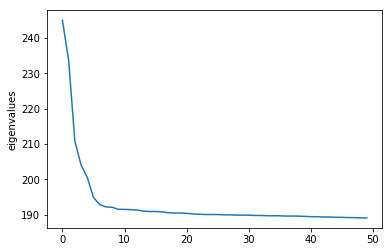

In [97]:
mat = mat = RowMatrix(pca_result.rdd.map(lambda v: Vectors.dense(v.pcaFeatures.toArray()) ))
svd = mat.computeSVD(50)
s = svd.s   
l = DenseVector(s)
plt.plot(l)
plt.ylabel('eigenvalues')
plt.show()

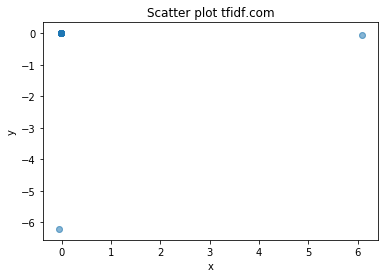

In [125]:
#pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")
#model = pca.fit(rescaledData)
#pca_result = model.transform(rescaledData).select("pcaFeatures")
#l=pca_result.select("pcaFeatures").collect()
xx=[]
yy=[]
for x in l[:5000]:
    xx.append(x[0][0])
    yy.append(x[0][1])
plt.scatter(xx, yy,alpha=0.1)
plt.title('Scatter plot tfidf.com')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [160]:
##2.e

nips=[]
vldb=[]
for x in all_data_list:
    if (len(x["title"]) != 0 ):
        if x["venue"] == 'NIPS':
            nips.append(x["title"].split(" "))
        if x["venue"] == 'VLDB':
            vldb.append(x["title"].split(" "))
l = nips+vldb

In [162]:
#tfidf:
df = pd.DataFrame({'title':l})
df = pd.DataFrame(df['title'].apply(lambda x: [item for item in x if item not in stop]))
df["title"] = (df["title"].apply(lambda x: ",".join(x) if isinstance(x, list) else x))
sentenceData = spark.createDataFrame(df) 
tokenizer = Tokenizer(inputCol="title", outputCol="words")
wordsData = tokenizer.transform(sentenceData)

hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=1000)
featurizedData = hashingTF.transform(wordsData)
# alternatively, CountVectorizer can also be used to get term frequency vectors

idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)


pca = PCA(k=50, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(rescaledData)

pca_result = model.transform(rescaledData).select("pcaFeatures")
print(sum(model.explainedVariance))

0.10464037434027815


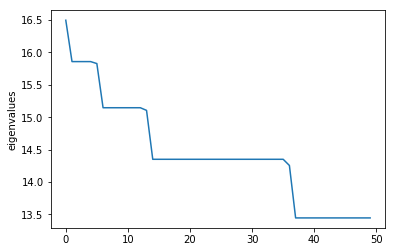

In [163]:
mat = mat = RowMatrix(pca_result.rdd.map(lambda v: Vectors.dense(v.pcaFeatures.toArray()) ))
svd = mat.computeSVD(50)
s = svd.s   
l = DenseVector(s)
plt.plot(l)
plt.ylabel('eigenvalues')
plt.show()

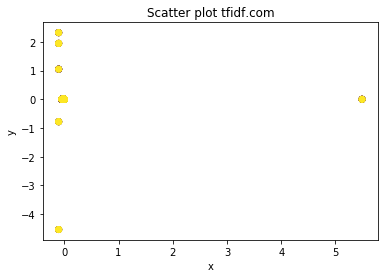

In [166]:
pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(rescaledData)
pca_result = model.transform(rescaledData).select("pcaFeatures")


l=pca_result.select("pcaFeatures").collect()
xx=[]
yy=[]


colors = [0]*len(nips) +[2]*len(vldb)
for x in l:
    xx.append(x[0][0])
    yy.append(x[0][1])
plt.scatter(xx, yy,c = colors)
plt.title('Scatter plot tfidf.com')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [167]:
## word count
l = nips+vldb
df = pd.DataFrame({'title':l})
df = pd.DataFrame(df['title'].apply(lambda x: [item for item in x if item not in stop]))
spark_df = spark.createDataFrame(df)
df = spark_df
# fit a CountVectorizerModel from the corpus.
cv = CountVectorizer(inputCol="title", outputCol="features", vocabSize=1000, minDF=0)
model = cv.fit(df)
result = model.transform(df)

In [168]:
pca = PCA(k=50, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(result)

pca_result = model.transform(result).select("pcaFeatures")
sum(model.explainedVariance)

0.3528786192556241

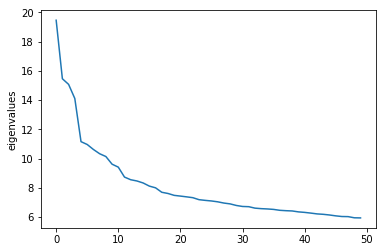

In [169]:
mat = RowMatrix(pca_result.rdd.map(lambda v: Vectors.dense(v.pcaFeatures.toArray()) ))
svd = mat.computeSVD(50)
s = svd.s   
l = DenseVector(s)
plt.plot(l)
plt.ylabel('eigenvalues')
plt.show()

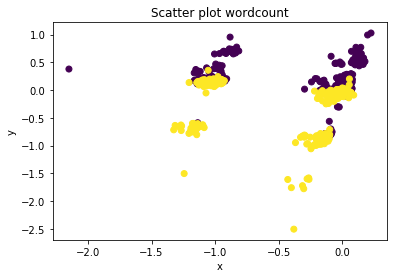

In [176]:
#scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
#scalerModel = scaler.fit(result)
#scaledData = scalerModel.transform(result)

pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(result)
pca_result = model.transform(result).select("pcaFeatures")


l=pca_result.select("pcaFeatures").collect()
xx=[]
yy=[]


colors = [0]*len(nips) +[5]*len(vldb)
for x in l:
    xx.append(x[0][0])
    yy.append(x[0][1])
plt.scatter(xx, yy,c = colors)
plt.title('Scatter plot wordcount')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [179]:
print((pca_result.count(), len(pca_result.columns)))

(2450, 1)
